In [1]:
from lxml import etree
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [2]:
# function to collect matching files and dirs
def collect_files(root, res, pattern="", collect_dirs=True):
    
    # go through all item in the dir
    for item in os.listdir(root):
        
        # process item
        item_path = os.path.join(root, item)
        item_is_dir = os.path.isdir(item_path)
        
        # pull valid file in res
        if re.match(pattern, item_path):
            if not item_is_dir or collect_dirs:
                res.append(item_path)
        
        # recursively collect all files
        if item_is_dir:
            collect_files(item_path, res, pattern, collect_dirs)

In [3]:
# collect all xml files
data_root = os.path.abspath("../acs-data/unzip-files/")
xml_files = []
collect_files(data_root, xml_files, pattern=".*\.xml$", collect_dirs=False)
print(f"total xml files: {len(xml_files)}")

total xml files: 1545


In [4]:
def extract_text_from_format(format_node):
    text = []
    if format_node.text:
        text.append(format_node.text.strip())
    for child in format_node:
        text.append(extract_text_from_format(child))
    return " ".join(text).replace("\n", " ")
            

In [5]:
def extract_title(citation_node):
    title = ""
    pub_type = None
    
    # get the publication type
    if "publication-type" in citation_node.attrib:
        pub_type = citation_node.attrib["publication-type"]
        
    # get the title
    title_node = citation_node.xpath("child::*[self::article-title or self::source][1]")
    
    if title_node:
        
        # remove formatting in title
        title_node = title_node[0]
        tmp_title = [title_node.text.strip()]
        for child in title_node:
            tmp_title.append(extract_text_from_format(child))
            tmp_title.append(child.tail.strip())
        title = " ".join(tmp_title)
        
    return (pub_type, title)

In [6]:
# ref_node is the ref-list element
def extract_ref_map(ref_list, verbose=True):
    
    def disp_warning(msg, attr):
        if verbose:
            print("at reference: %s" % repr(attr))
            print(msg)
            print("title will be: \"\"")
            
    ref_map = {}
    for ref in ref_list.xpath("child::ref"):
        
        rid = ref.attrib["id"]
        
        # extract citation title
        citation_node = ref.xpath("child::*[1]")[0]
        pub_type, title = extract_title(citation_node)
        
        # check pub_type and title
        if pub_type is None:
            disp_warning("publication type doesn't exist", ref.attrib)
        if title == "":
            disp_warning("for publication type %s: title doesn't exist" % pub_type, ref.attrib)
        
        # remove newlines in the title
#         title = title.replace("\n", " ")
        
        # set up the map
        ref_map[rid] = title
            
    return ref_map

In [7]:
def extract_text(root, verbose=True):
    
    def disp_warning(attr):
        if verbose:
            print("can't handle attr: %s" % repr(attr))
            print("will use \"UNK\" for substitution")
    
    # extract references
    ref_list = root.xpath("//ref-list[1]")
    if ref_list:
        ref_map = extract_ref_map(ref_list[0], verbose)
    
    # find the interesting tags
    lines = []
    conditions = [
        "(self::p or self::title) and",
        "not(ancestor::glossary) and",
        "not(ancestor::ack) and",
        "not(ancestor::ref-list) and",
        "not(ancestor::notes)"
    ]
    for item in root.xpath("//*[%s]" % " ".join(conditions)):
        
        # the tag is a title
        if item.tag == "title":
            lines.append(item.text.strip())
            
        # the tag is a paragraph
        elif item.tag == "p":
            
            # skip p if text is None
            if item.text is None:
                continue
                
            phrases = [item.text.strip()]
            for child in item:
                
                for ref in child.xpath("descendant-or-self::xref"):
                    
                    # handle reference
                    # this part is disabled for now
                    attr = ref.attrib
                    if "ref-type" in attr and attr["ref-type"] == "bibr":
                        pass
#                         rid = attr["rid"]
#                         if rid in ref_map:
#                             phrases.append("REF %s REFEND" % ref_map[rid])
#                         else:
#                             disp_warning(attr)
                        
                    # handle base on rid type
                    elif "rid" in attr:
                        
                        # handle notes
                        if re.match("^note-\d+$", attr["rid"]):
                            phrases.append(ref.text)

                        # handle figures
                        elif re.match("^fig\d+$", attr["rid"]):
                            phrases.append("FIG")
                        
                        # handle equation
                        elif re.match("^eq\d+$", attr["rid"]):
                            phrases.append("EQL")

                    # exception
                    else:
                        disp_warning(attr)
                        phrases.append("UNK")
                        
                # if the child is a formatting element, include the text inside
                if child.tag in ("sup", "sub", "italic", "bold"):
                    phrases.append(extract_text_from_format(child))
                
                # put the text following the child element
                phrases.append(child.tail.strip())
                
            line = " ".join(phrases)
            line = line.strip().replace("\n", " ")
            lines.append(line)
    return lines

In [8]:
def get_pub_date(root):
    
    res = []
    
    # find all different type of publication date
    pub_date_nodes = root.xpath("/article/front/article-meta/pub-date")
    
    # the the year, month, day
    for node in pub_date_nodes:
        
        # extract type
        pub_type = " ".join(sorted(list(node.attrib.values())))
        
        # extract date
        pub_date = (node.xpath("./year"), node.xpath("./month"), node.xpath("./day"))
        pub_date = tuple(map(lambda x: x[0].text, pub_date))
        
        res.append((pub_type, pub_date))
    
    return res

In [9]:
# publication dates of all articles
pub_dates = []

for f in tqdm(xml_files):
    
    print(f"parsing: {f}")
    
    tree = etree.parse(f)
    root = tree.getroot()
    
    lines = extract_text(root, True)
    
    pub_dates.append(get_pub_date(root))
    
    # save to folder
    # change the .xml extensino to .txt
    fname = f.split("/")[-1].split(".")[0] + ".txt"
    
    # write to disk
    with open(os.path.join("../acs-data/txt-files", fname), "w", encoding="utf-8") as f:
        for line in lines:
            f.write(line + "\n")

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00050/sb7b00050.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00301/sb6b00301.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300068g/sb300068g.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00050/sb6b00050.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00034/sb6b00034.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00187/sb5b00187.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00088/sb7b00088.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00471/sb8b00471.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400072v/sb400072v.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300069k/sb300069k.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00194/sb8b00194.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500331x/sb500331x.xml
at reference: {'id': 'ref53'}
for publication type weblink: title doesn't exist
title will be: ""
pa

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00333/sb7b00333.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00147/sb7b00147.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00134/sb6b00134.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00134/sb8b00134.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00431/sb7b00431.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00532/sb8b00532.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00135/sb8b00135.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00336/sb6b00336.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00459/sb7b00459.xml
at reference: {'id': 'ref11'}
publication type doesn't exist
title will be: ""
at reference: {'id': 'ref12'}
publication type doesn't exist
title will be: ""
at reference: {'id': 'ref17'}
publication type doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500345t/sb500345t.xml
parsing: /hom

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00159/sb6b00159.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00327/sb7b00327.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500257f/sb500257f.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500362n/sb500362n.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb200003v/sb200003v.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00145/sb6b00145.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00179/sb5b00179.xml
at reference: {'id': 'ref30'}
publication type doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00041/sb9b00041.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00124/sb7b00124.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00111/sb5b00111.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300098w/sb300098w.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00110/sb9b00110.xml
parsing: /home/jiawei

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb2000275/sb2000275.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400039g/sb400039g.xml
at reference: {'id': 'ref5'}
publication type doesn't exist
title will be: ""
at reference: {'id': 'ref5'}
for publication type None: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00196/sb5b00196.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00121/sb8b00121.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00284/sb8b00284.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00457/sb8b00457.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00100/sb5b00100.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300082b/sb300082b.xml
at reference: {'id': 'ref18'}
publication type doesn't exist
title will be: ""
at reference: {'id': 'ref18'}
for publication type None: title doesn't exist
title will be: ""
at reference: {'id': 'ref26'}
for publication type web

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00076/sb6b00076.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00427/sb8b00427.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00467/sb7b00467.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb3001062/sb3001062.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400115e/sb400115e.xml
at reference: {'id': 'ref1'}
for publication type patent: title doesn't exist
title will be: ""
at reference: {'id': 'ref2'}
for publication type patent: title doesn't exist
title will be: ""
at reference: {'id': 'ref3'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400147n/sb400147n.xml
at reference: {'id': 'ref29'}
for publication type unpublished: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300047u/sb300047u.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00078/sb6b00078.xml
parsing: 

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500019b/sb500019b.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00232/sb5b00232.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00091/sb8b00091.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00320/sb7b00320.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb200007r/sb200007r.xml
at reference: {'id': 'ref11'}
publication type doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00277/sb7b00277.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00075/sb6b00075.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00073/sb9b00073.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00509/sb8b00509.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300074k/sb300074k.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00172/sb7b00172.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400032x/sb400032x.xml
parsing: /home/jiawei

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300040v/sb300040v.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400030p/sb400030p.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00241/sb8b00241.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00204/sb9b00204.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00303/sb5b00303.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00125/sb6b00125.xml
at reference: {'id': 'ref30'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00304/sb8b00304.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00337/sb6b00337.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500332c/sb500332c.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00151/sb8b00151.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00263/sb6b00263.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb2000066/sb2000066.xml
pa

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00122/sb9b00122.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00028/sb7b00028.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00192/sb9b00192.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00442/sb8b00442.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5002246/sb5002246.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00047/sb9b00047.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500059x/sb500059x.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00399/sb7b00399.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00223/sb5b00223.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00027/sb6b00027.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00323/sb6b00323.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00271/sb8b00271.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400045k/sb400045k.xml
at reference: {'id': 'ref

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb4001504/sb4001504.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb3001326/sb3001326.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00287/sb8b00287.xml
at reference: {'id': 'ref26'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00037/sb6b00037.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00004/sb6b00004.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb4001382/sb4001382.xml
at reference: {'id': 'ref6'}
for publication type weblink: title doesn't exist
title will be: ""
at reference: {'id': 'ref8'}
publication type doesn't exist
title will be: ""
at reference: {'id': 'ref8'}
for publication type None: title doesn't exist
title will be: ""
at reference: {'id': 'ref47'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00014/sb8b00014.xml
parsing: /

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400203p/sb400203p.xml
at reference: {'id': 'ref16'}
publication type doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00328/sb7b00328.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00083/sb6b00083.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00130/sb6b00130.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00409/sb7b00409.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00119/sb8b00119.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00172/sb8b00172.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00140/sb6b00140.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00111/sb9b00111.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00007/sb7b00007.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500003x/sb500003x.xml
at reference: {'id': 'ref17'}
for publication type weblink: title doesn't exist
title will be: "

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00252/sb5b00252.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300107h/sb300107h.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00284/sb6b00284.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400024s/sb400024s.xml
at reference: {'id': 'ref11'}
publication type doesn't exist
title will be: ""
at reference: {'id': 'ref11'}
for publication type None: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400048b/sb400048b.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500304m/sb500304m.xml
at reference: {'id': 'ref7'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00416/sb7b00416.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00057/sb8b00057.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5000884/sb5000884.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00064/sb6b00064.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500113b/sb500113b.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00103/sb9b00103.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00239/sb6b00239.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00371/sb6b00371.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300055e/sb300055e.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00309/sb8b00309.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400133g/sb400133g.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00317/sb8b00317.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00112/sb7b00112.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb3000589/sb3000589.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00505/sb8b00505.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00032/sb6b00032.xml
parsing: /home/jiawei/bio

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300116y/sb300116y.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb2000287/sb2000287.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00211/sb6b00211.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00416/sb8b00416.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00006/sb7b00006.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00163/sb5b00163.xml
at reference: {'id': 'ref21'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00361/sb8b00361.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00165/sb5b00165.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00005/sb9b00005.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00087/sb5b00087.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5002533/sb5002533.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00432/sb8b00432.xml
pa

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400076r/sb400076r.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb500234s/sb500234s.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00167/sb6b00167.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00406/sb8b00406.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00274/sb8b00274.xml
at reference: {'id': 'ref78'}
for publication type patent: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00314/sb8b00314.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00395/sb6b00395.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00176/sb8b00176.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb4001323/sb4001323.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00397/sb6b00397.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00148/sb6b00148.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb4000355/sb4000355.xml
par

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00255/sb9b00255.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00193/sb5b00193.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00274/sb5b00274.xml
at reference: {'id': 'ref35'}
for publication type weblink: title doesn't exist
title will be: ""
at reference: {'id': 'ref36'}
for publication type weblink: title doesn't exist
title will be: ""
at reference: {'id': 'ref38'}
for publication type weblink: title doesn't exist
title will be: ""
at reference: {'id': 'ref39'}
for publication type weblink: title doesn't exist
title will be: ""
at reference: {'id': 'ref55'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00201/sb8b00201.xml
at reference: {'id': 'ref36'}
for publication type conf-proc: title doesn't exist
title will be: ""
at reference: {'id': 'ref50'}
for publication type unpublished: title doesn't exist
title will be: ""
parsing:

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00400/sb8b00400.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400055h/sb400055h.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300094q/sb300094q.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb4000096/sb4000096.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00137/sb6b00137.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb9b00293/sb9b00293.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400135t/sb400135t.xml
at reference: {'id': 'ref38'}
for publication type weblink: title doesn't exist
title will be: ""
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400182x/sb400182x.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00131/sb5b00131.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00423/sb7b00423.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb400197f/sb400197f.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00331/sb6b00331.xml
pa

parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00010/sb6b00010.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300001c/sb300001c.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300053s/sb300053s.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00240/sb5b00240.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb200005w/sb200005w.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00120/sb6b00120.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00048/sb7b00048.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb5b00261/sb5b00261.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb7b00115/sb7b00115.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00138/sb8b00138.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb8b00487/sb8b00487.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb300007g/sb300007g.xml
parsing: /home/jiawei/biobert/acs-data/unzip-files/sb6b00245/sb6b00245.xml
parsing: /home/jiawei/bio

(array([  0.,  11., 101., 133., 179., 132., 224., 256., 282., 227.,   0.]),
 array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
        2021]),
 <a list of 11 Patch objects>)

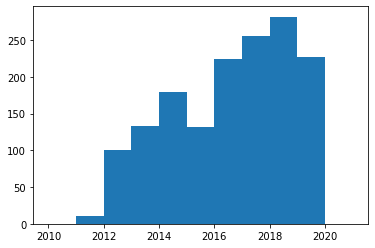

In [10]:
# plot out the publication dates
epub_years = []
for date in pub_dates:
    for d in date:
        if d[0] in ("electronic pub", "epub"):
            epub_years.append(int(d[1][0]))

plt.hist(epub_years, bins=[x for x in range(2010, 2022)])